Нашей задачей является решение системы дифференциальных уравнений
$$
    \frac{d^2 x^\nu}{ds} =- \Gamma_{\alpha\beta}^\nu \frac{dx^\alpha}{ds} \frac{dx^\beta}{ds}.
$$
Поскольку в Python хорошо прописано уравнений первого порядка, перепишем нашу систему следующим образом:
$$
    \frac{d}{ds} 
    \begin{pmatrix}
        x^\nu\\
        dx^\nu / ds
    \end{pmatrix} = 
    \begin{pmatrix}
        dx^\nu / ds\\
        -\Gamma_{\alpha\beta}^\nu (dx^\alpha / ds) (dx^\beta / ds)
    \end{pmatrix}.
$$
Именно это уравнение с разными начальными или граничными условиями мы и будем решать.

Ниже функция `rhs(q, s, M)` возвращает правую часть уравнения, представленного выше; q -- это массив, первые четыре элементы которого равны $x^\nu$, а последующие -- $dx^\nu/ds$.

In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def rhs(q, s, M):
    f = np.zeros(q.shape)
    x = q[:4]
    velocities = q[4:]
    f[:4] = velocities
    t, rho, theta, phi = x
    Gamma = np.zeros((4,4,4))
    Gamma[0,0,1] = M / rho**2 * (1 - 2 * M / rho)
    Gamma[0,1,0] = M / (
        rho**2 * (1 - 2 * M / rho)
    )
    Gamma[1,1,1] = -M / (
        rho**2 * (1 - 2 * M / rho)
    )
    Gamma[1,2,2] = 1 / rho
    Gamma[1,3,3] = 1 / rho
    Gamma[2,2,1] = - rho * (
        1 - 2 * M / rho
    )
    Gamma[3,3,1] = - rho * ( 
        1 - 2 * M / rho
    ) * np.sin(theta) ** 2
    Gamma[2,3,3] = np.cos(theta) / np.sin(theta)
    Gamma[3,3,2] = -np.sin(theta) * np.cos(theta)
    for i in range(4):
        Gamma[:,:,i] = Gamma[:,:,i] + np.transpose(Gamma[:,:,i])
        Gamma[:,:,i] = Gamma[:,:,i] - np.diag(np.diag(Gamma[:,:,i]))/2
        f[4 + i] = -velocities @ Gamma[:,:,i] @ velocities
    return f

Решим систему уравнений для какого-то просто случая, когда заданы начальные условия. Тогда мы найдём геодезическую, проходящую через точку $x^\nu(0)$ и имеющую касательную в этой точке равную $\frac{dx^\nu}{ds} (0)$. 

In [8]:
M = 1
x_initial = np.array([
    0, 10, np.pi/2, 0
])
v_initial = np.array([
    1, 0, 0, 0.03
])
xv_initial = np.concatenate((
    x_initial, v_initial
))
s_steps = np.linspace(0, 500, 5000)
xv_sol = odeint(rhs, xv_initial, s_steps, args=(M,))

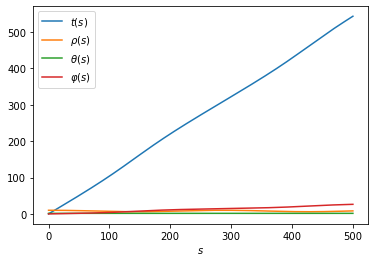

In [9]:
x_sol = xv_sol[:,:4]
plt.plot(s_steps, x_sol)
plt.legend([
    '$t (s)$',
    r'$\rho (s)$',
    r'$\theta (s)$',
    r'$\varphi (s)$'
])
plt.xlabel('$s$')
plt.show()

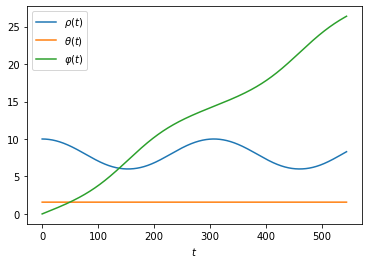

In [10]:
t, coordinates = x_sol[:,0], x_sol[:,1:4]
plt.plot(t, coordinates)
plt.legend([
    r'$\rho (t)$',
    r'$\theta (t)$',
    r'$\varphi (t)$'
])
plt.xlabel('$t$')
plt.show()

Поскольку угловой момент сохраняется, а также $\theta = \pi/2$ и $d \theta / ds = 0$, геодезическая лежит в плоскости $(x, y)$. Нарисуем её. 

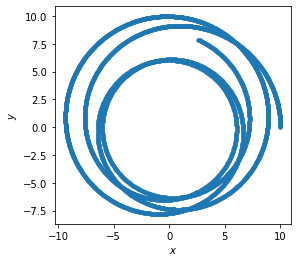

In [11]:
x = xv_sol[:,1] * np.cos(xv_sol[:,3])
y = xv_sol[:,1] * np.sin(xv_sol[:,3])

plt.scatter(x, y, marker='.')
plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig("myImagePDF.pdf", format="pdf", bbox_inches="tight")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()